# Leverage


### Stupidity or genius?

Updated 2020-August-28.


* This notebook looks at what the last 92 years of daily S&P 500 data has to say about the now well-known intra-day leverage.  

* Automatic reinvestment of dividends is assumed. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Constants

In [2]:
# Number of trading days in a year
N_YEAR = 252

# 2x dividends as a fraction of S&P 500 dividends, 
# assumed from the current ratio of SSO to SPY dividends
DIV2 = 0.18

# Explored leverage space (0% leverage to 100% leverage)
lev = np.linspace(0, 1, 41)

### Load Data

In [3]:
# S&P 500 daily - from Yahoo Finance
df = pd.read_csv('../data/^GSPC.csv', index_col=0, parse_dates=[0])

In [4]:
# S&P 500 annual average dividend - from Quandl
dfi = pd.read_csv('../data/MULTPL-SP500_DIV_YIELD_YEAR-annual.csv', 
                  index_col=0, parse_dates=[0])

dividend_year = dict(zip(dfi.index.year, dfi.Value.to_numpy()))
df['DividendYear'] = df.index.map(lambda x: dividend_year[x.year]) / 100

In [5]:
df

,Open,High,Low,Close,Adj Close,Volume,DividendYear
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0,0.0441
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0,0.0367
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0,0.0367
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0,0.0367
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0,0.0367
...,...,...,...,...,...,...,...
2020-08-24,3418.090088,3432.090088,3413.129883,3431.280029,3431.280029,3728690000,0.0182
2020-08-25,3435.949951,3444.209961,3425.840088,3443.620117,3443.620117,3619300000,0.0182
2020-08-26,3449.969971,3481.070068,3444.149902,3478.729980,3478.729980,3754360000,0.0182


### Create Daily Leverage

In [6]:
dl = (df.Close / df.Close.shift()).iloc[1:]

In [7]:
div = df.DividendYear.iloc[1:]

Each entry of `dl` is the end of day multiple of the previous trading day's closing price, such that 1.05 would indicate a 5% increase. 

In [8]:
# How many trading days in a year, i.e., how long to rebalance? 
# We will settle on the standard 252 trading days
dl.groupby(dl.index.year).count().value_counts()

252    31
253    21
251    14
250    14
249     5
254     3
248     1
246     1
242     1
226     1
167     1
Name: Close, dtype: int64

In [9]:
# Long-term accuracy is good, as expected
assert np.round(np.product(dl), 5) == np.round(df.Close[-1] / df.Close[0], 5)

In [10]:
dl2 = 2*(dl-1) + 1

## All n-Year periods since 1927

We assume n = 10 and annual (252 trading days) rebalancing of leverage percentages. 

#### Constants

In [11]:
num_years = 10
n_period = num_years * N_YEAR
len_chunk = n_period
len_sep = 1

n_split = N_YEAR
rebalance_idxs = np.arange(n_split, n_period, n_split)

#### Get the index architecture

In [12]:
assert dl.size == dl2.size

In [13]:
%%time
n_arrays = np.int(np.ceil((dl.size - len_chunk + 1) / len_sep))

rows = np.array((np.arange(n_arrays).reshape(n_arrays, -1) + np.tile(
                np.zeros(len_chunk), n_arrays).reshape(n_arrays, -1)), dtype=np.intp)
columns = np.array(((len_sep*np.arange(0, n_arrays)).reshape(n_arrays, -1) + np.tile(
                np.arange(0, len_chunk), n_arrays).reshape(n_arrays, -1)), dtype=np.intp)

CPU times: user 818 ms, sys: 772 ms, total: 1.59 s
Wall time: 1.78 s


In [14]:
n_arrays

20756

#### Get the start dates

In [15]:
start_dates = dl.index[:n_arrays:len_sep]

#### Get the periods

In [16]:
def get_periods(array):
    return np.tile(array, n_arrays).reshape(n_arrays, -1)[rows, columns]

In [17]:
%%time
dlm = get_periods(dl.to_numpy())

CPU times: user 1.53 s, sys: 3.2 s, total: 4.73 s
Wall time: 8.74 s


In [18]:
%%time 
dlm2 = get_periods(dl2.to_numpy())

CPU times: user 1.42 s, sys: 1.26 s, total: 2.68 s
Wall time: 2.78 s


#### Combine with Dividend Data

In [19]:
%%time
divm = get_periods(div.to_numpy())

CPU times: user 1.37 s, sys: 1.26 s, total: 2.64 s
Wall time: 3 s


In [20]:
print(dlm.shape)
assert dlm.shape == dlm2.shape == divm.shape
assert dlm.shape[0] == n_arrays

(20756, 2520)


In [21]:
divmsplit = np.array(np.hsplit(divm, rebalance_idxs)).T

divmsplit = np.average(divmsplit, axis=0)

divmsplit2 = divmsplit * DIV2

#### Get returns from each year

In [22]:
%%time
dlmsplit = np.array(np.hsplit(dlm, rebalance_idxs)).T
dlmsplit = np.product(dlmsplit, axis=0)
dlmsplit += divmsplit

CPU times: user 290 ms, sys: 740 ms, total: 1.03 s
Wall time: 2.09 s


In [23]:
%%time
dlmsplit2 = np.array(np.hsplit(dlm2, rebalance_idxs)).T
dlmsplit2 = np.product(dlmsplit2, axis=0)
dlmsplit2 += divmsplit2

CPU times: user 208 ms, sys: 275 ms, total: 483 ms
Wall time: 606 ms


#### Aggregate the results over the n-years with varying leverage rates

In [24]:
agg2 = (1-lev).reshape(-1, 1, 1)*dlmsplit + lev.reshape(-1, 1, 1)*dlmsplit2

results2 = np.product(agg2.T, axis=0)

In [25]:
print(results2.shape)

(20756, 41)


#### Get results relative to baseline (S&P 500)

In [26]:
relative2 = results2 / results2[:,0].reshape(n_arrays, -1)

#### Plot many leverage curves

CPU times: user 7.85 s, sys: 165 ms, total: 8.02 s
Wall time: 7.85 s


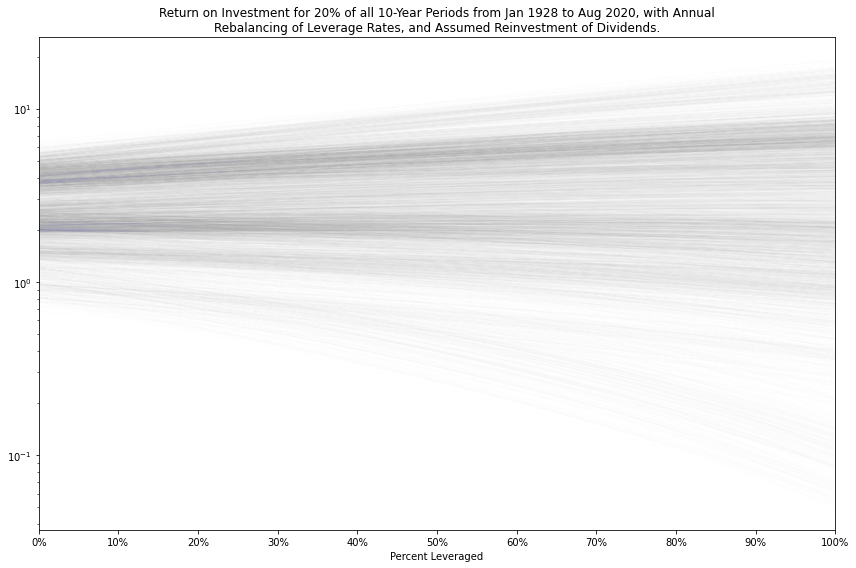

In [27]:
%%time
plt.figure(figsize=(12, 8))
for i in range(0, n_arrays, 5):
    plt.plot(lev, results2[i], alpha=0.005, color='#1f77b4')
    
plt.yscale('log')
plt.xticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.xlim(0, 1)
plt.xlabel('Percent Leveraged')
plt.title('Return on Investment for 20% of all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.'.format(num_years))
plt.tight_layout();
plt.savefig('plots/leverage-2x-10yr-many_lev_curves.png', dpi=300);

### Plotting leverage curves by percentile

In [28]:
quantiles = np.linspace(0, 1, 101, endpoint=True)
results2q = np.quantile(results2, quantiles, axis=0)

scheme = sns.color_palette('viridis', quantiles.size)

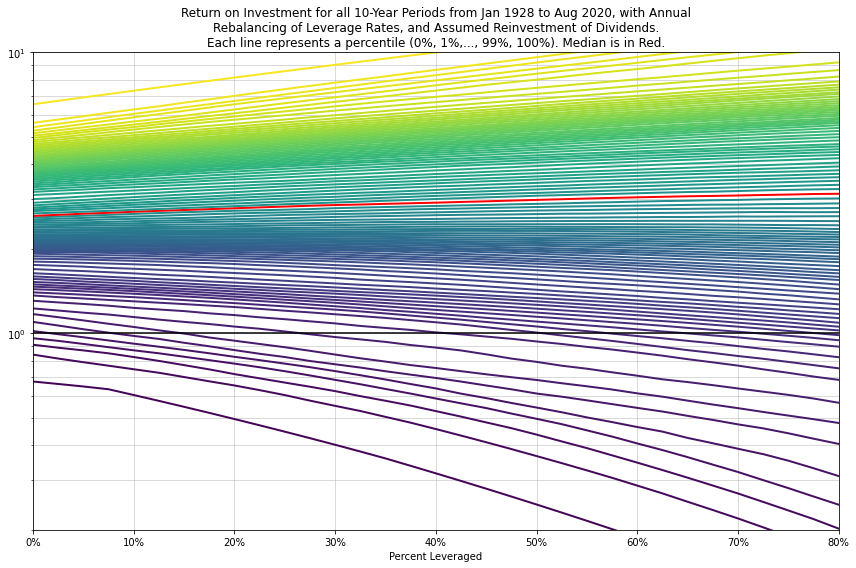

In [48]:
plt.figure(figsize=(12, 8))
for i, quant in enumerate(quantiles):
    results2q[i]
    color = scheme[i]
    label = None
    if quant == 0.5:
        color = 'r'
        label = 'Median'
    plt.plot(lev, results2q[i], 
             color=color, label=label, linewidth=2)
    
plt.yscale('log')
plt.xticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.axhline(y=1, color='k')
plt.xlim(0, 0.8)
plt.ylim(.2, 10)
plt.xlabel('Percent Leveraged')
plt.grid(alpha=0.6, which='both')
plt.title('Return on Investment for all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.\n\
Each line represents a percentile (0%, 1%,..., 99%, 100%). Median is in Red.'.format(num_years))
plt.tight_layout();
plt.savefig('plots/leverage-2x-10yr-percentiles.png', dpi=300);

In [31]:
relative2q = np.quantile(relative2, quantiles, axis=0)

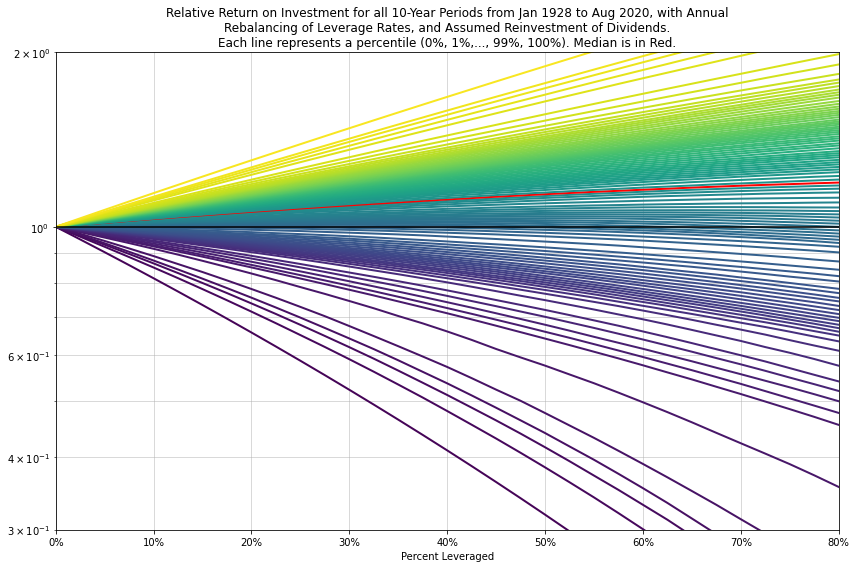

In [50]:
plt.figure(figsize=(12, 8))
for i, quant in enumerate(quantiles):
    relative2q[i]
    color = scheme[i]
    label = None
    if quant == 0.5:
        color = 'r'
        label = 'Median'
    plt.plot(lev, relative2q[i], 
             color=color, label=label, linewidth=2)
    
plt.yscale('log')
plt.xticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.axhline(y=1, color='k')
plt.xlim(0, 0.8)
plt.ylim(.3, 2)
plt.xlabel('Percent Leveraged')
plt.grid(alpha=0.6, which='both')
plt.title('Relative Return on Investment for all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.\n\
Each line represents a percentile (0%, 1%,..., 99%, 100%). Median is in Red.'.format(num_years))
plt.tight_layout();
plt.savefig('plots/leverage-2x-10yr-relative-percentiles.png', dpi=300);

#### Limited quantiles

In [33]:
quantiles2 = np.array([0.05, 0.15, 0.25, 0.4, 0.6, 0.75, 0.85, 0.95])[::-1]
scheme2 = sns.color_palette('viridis', quantiles2.size)[::-1]

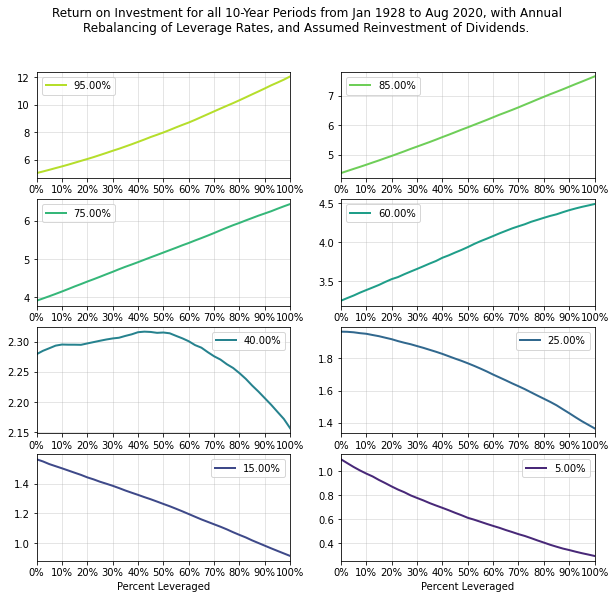

In [34]:
fig, ax = plt.subplots(4, 2, figsize=(10, 9))

for i, quant in enumerate(quantiles2):
    cur_ax = ax.ravel()[i]
    q_array = np.quantile(results2, quant, axis=0)
    color = scheme2[i]
    cur_ax.plot(lev, q_array, 
             color=color, label='{:.2%}'.format(quant), linewidth=2)
    
    cur_ax.set_xticks(lev[::4])
    cur_ax.set_xticklabels(['{:.0%}'.format(p) for p in lev[::4]])
    cur_ax.set_xlim(0, 1)
    cur_ax.grid(alpha=0.4)
    cur_ax.set_xlabel('Percent Leveraged')
    cur_ax.legend()
    
fig.suptitle('Return on Investment for all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.'.format(num_years))

plt.savefig('plots/leverage-2x-10yr-limited_percentiles.png', dpi=300);

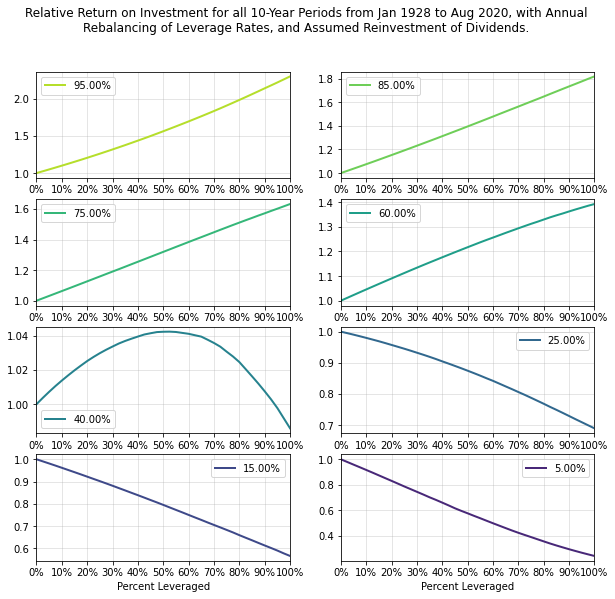

In [35]:
fig, ax = plt.subplots(4, 2, figsize=(10, 9))

for i, quant in enumerate(quantiles2):
    cur_ax = ax.ravel()[i]
    q_array = np.quantile(relative2, quant, axis=0)
    color = scheme2[i]
    cur_ax.plot(lev, q_array, 
             color=color, label='{:.2%}'.format(quant), linewidth=2)
    
    cur_ax.set_xticks(lev[::4])
    cur_ax.set_xticklabels(['{:.0%}'.format(p) for p in lev[::4]])
    cur_ax.set_xlim(0, 1)
    cur_ax.grid(alpha=0.4)
    cur_ax.set_xlabel('Percent Leveraged')
    cur_ax.legend()
    
fig.suptitle('Relative Return on Investment for all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.'.format(num_years))

plt.savefig('plots/leverage-2x-10yr-relative-limited_percentiles.png', dpi=300);

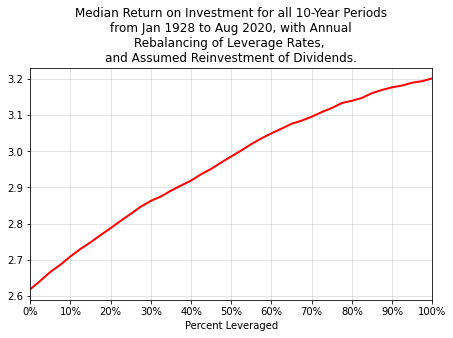

In [36]:
plt.figure(figsize=(6.4, 4.8))
q = 0.5
q_array = np.quantile(results2, q, axis=0)
plt.plot(lev, q_array, color='r', linewidth=2)
    
plt.xticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.xlim(0, 1)

plt.xlabel('Percent Leveraged')
plt.grid(alpha=0.4)
plt.title('Median Return on Investment for all {}-Year Periods\n\
from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, \n\
and Assumed Reinvestment of Dividends.'.format(num_years));
plt.tight_layout();
plt.savefig('plots/leverage-2x-10yr-median.png', dpi=300);

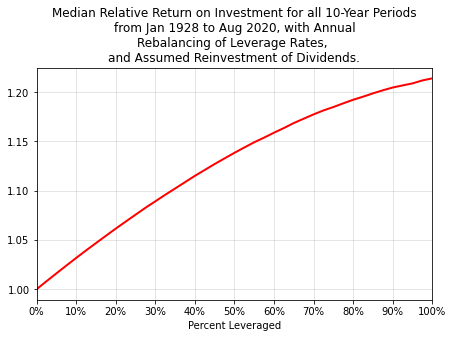

In [37]:
plt.figure(figsize=(6.4, 4.8))
q = 0.5
q_array = np.quantile(relative2, q, axis=0)
plt.plot(lev, q_array, color='r', linewidth=2)
    
plt.xticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.xlim(0, 1)

plt.xlabel('Percent Leveraged')
plt.grid(alpha=0.4)
plt.title('Median Relative Return on Investment for all {}-Year Periods\n\
from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, \n\
and Assumed Reinvestment of Dividends.'.format(num_years));
plt.tight_layout();
plt.savefig('plots/leverage-2x-relative-10yr-median.png', dpi=300);

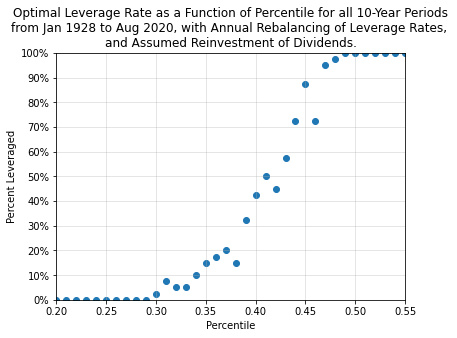

In [38]:
plt.figure(figsize=(6.4, 4.8))
plt.scatter(quantiles, lev[np.argmax(results2q, axis=1)])

plt.yticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.ylabel('Percent Leveraged')

plt.xlim(0.2, 0.55)
plt.xlabel('Percentile')

plt.grid(alpha=.4)
plt.ylim(0, 1)

plt.title('Optimal Leverage Rate as a Function of Percentile for all {}-Year Periods\n\
from Jan 1928 to Aug 2020, with Annual Rebalancing of Leverage Rates, \n\
and Assumed Reinvestment of Dividends.'.format(num_years))

plt.tight_layout();
plt.savefig('plots/leverage-2x-10yr-optimal_leverage.png', dpi=300);


### Compare histograms of 0% and 50% leveraged.

In [39]:
idx50 = 20
lev[idx50]

0.5

In [40]:
print(np.quantile(results2[:,0], 0.5), np.quantile(results2[:,idx50], 0.5))

2.6187850357727385 2.9857276504515733


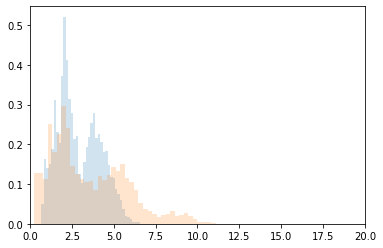

In [41]:
plt.hist(results2[:,0], bins=40, alpha=0.2, density=True)

plt.hist(results2[:,idx50], 
         bins=40, alpha=0.2, density=True)
plt.xlim(0, 20);

### What were some of the craziest n-year returns, and when were they?

#### Maximum returns

In [42]:
maximums = np.unique(np.argmax(results2, axis=0))

In [43]:
# 0% leverage, 100% leverage
results2[maximums][:,0], results2[maximums][:,-1]

(array([6.53838369, 5.87524872, 5.85295388]),
 array([17.38484962, 19.69918514, 19.6194711 ]))

In [44]:
start_dates[maximums]

DatetimeIndex(['1949-06-14', '1990-09-25', '1990-10-12'], dtype='datetime64[ns]', name='Date', freq=None)

#### Minimum returns

In [45]:
minimums = np.unique(np.argmin(results2, axis=0))

In [46]:
# 0% leverage, 100% leverage
results2[minimums][:,0], results2[minimums][:,-1]

(array([0.77237116, 0.725557  , 0.6740997 ]),
 array([0.05140525, 0.04749801, 0.1996363 ]))

In [47]:
start_dates[minimums]

DatetimeIndex(['1929-09-04', '1930-04-21', '1999-02-24'], dtype='datetime64[ns]', name='Date', freq=None)